# ***GANs VS VAEs***

# **Part 1: Exploratory Data Analysis (EDA)**

## **1. Load the Datasets**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# a. Download and Load the MNIST Digits and MNIST Fashion datasets.
(x_train_digits, y_train_digits), (x_test_digits, y_test_digits) = tf.keras.datasets.mnist.load_data()

#Download and Load the MNIST Fashion datasets.
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **2. Preview the Datasets**

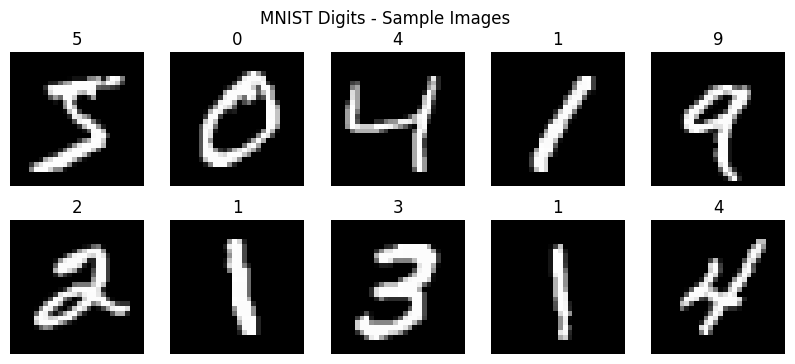

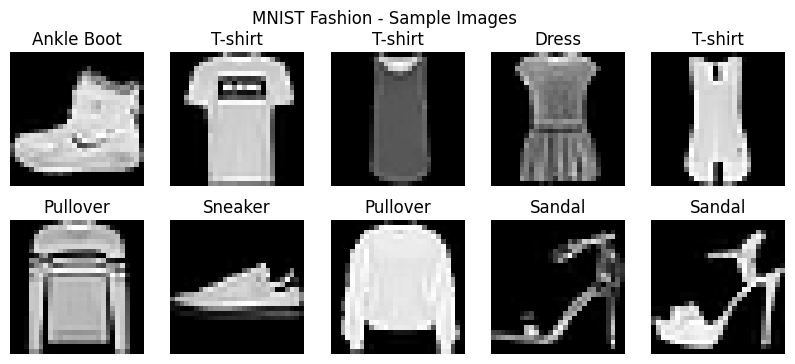

In [ ]:
#Display sample images from MNIST Digits and MNIST Fashion to understand their structure.
def plot_sample_images(dataset, labels, class_names, title):
    plt.figure(figsize=(10, 4))
    for i in range(10):  # Show 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(dataset[i], cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Define class names for MNIST Digits and MNIST Fashion
mnist_digit_classes = [str(i) for i in range(10)]  # Digits 0-9
mnist_fashion_classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Display sample images
plot_sample_images(x_train_digits, y_train_digits, mnist_digit_classes, "MNIST Digits - Sample Images")
plot_sample_images(x_train_fashion, y_train_fashion, mnist_fashion_classes, "MNIST Fashion - Sample Images")

## **3. Dataset Analysis**

In [ ]:
print("MNIST Digits Dataset:")
# a. Determine the number of samples in each dataset.
print(f"Training Samples: {x_train_digits.shape[0]}, Test Samples: {x_test_digits.shape[0]}")
print(f"Image Shape: {x_train_digits.shape[1:]}")  # Should be (28,28)
#b. Identify the number of classes and their labels in the MNIST Digits and MNIST Fashion datasets.
print(f"Number of Classes: {len(set(y_train_digits))}, Labels: {mnist_digit_classes}")

print("\nMNIST Fashion Dataset:")
# a. Determine the number of samples in each dataset.
print(f"Training Samples: {x_train_fashion.shape[0]}, Test Samples: {x_test_fashion.shape[0]}")
print(f"Image Shape: {x_train_fashion.shape[1:]}")  # Should be (28,28)
# b. Identify the number of classes and their labels in the MNIST Digits and MNIST Fashion datasets.
print(f"Number of Classes: {len(set(y_train_fashion))}, Labels: {mnist_fashion_classes}")

MNIST Digits Dataset:
Training Samples: 60000, Test Samples: 10000
Image Shape: (28, 28)
Number of Classes: 10, Labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

MNIST Fashion Dataset:
Training Samples: 60000, Test Samples: 10000
Image Shape: (28, 28)
Number of Classes: 10, Labels: ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']


# **Part 2: Implementing Generative Adversarial Networks (GANs)**

## **GAN Model Architecture**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_generator():
    model = keras.Sequential([
        Dense(128, input_dim=100),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        Dense(784, activation="tanh"),  # Output 28x28 pixels (flattened)
        Reshape((28, 28))  # Reshape to image format
    ])
    return model

In [ ]:
def build_discriminator():
    model = keras.Sequential([
        Flatten(input_shape=(28, 28)),  # Flatten image
        Dense(512),
        LeakyReLU(alpha=0.2),

        Dense(256),
        LeakyReLU(alpha=0.2),

        Dense(1, activation="sigmoid")  # Output: probability of being real
    ])
    return model


In [ ]:
def build_gan(generator, discriminator):
    discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.0002, 0.5), metrics=["accuracy"])
    discriminator.trainable = False  # Freeze discriminator during GAN training

    model = keras.Sequential([
        generator,
        discriminator
    ])

    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.0002, 0.5))
    return model


In [ ]:
# Load MNIST Digits dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize to [-1,1]
x_train = np.expand_dims(x_train, axis=-1)

# Hyperparameters
epochs = 5000
batch_size = 128
sample_interval = 1000
noise_dim = 100

# Build Models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training Loop
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train Discriminator
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_images = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Print Progress
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

In [ ]:
# Load Fashion MNIST dataset
(x_train_fashion, y_train_fashion), (_, _) = keras.datasets.fashion_mnist.load_data()
x_train_fashion = x_train_fashion / 127.5 - 1.0  # Normalize
x_train_fashion = np.expand_dims(x_train_fashion, axis=-1)

# Select only "Sneaker" class (Label 7)
shoe_images = x_train_fashion[y_train_fashion == 7]

# Training the GAN on only shoe images
for epoch in range(epochs):
    real_images = shoe_images[np.random.randint(0, shoe_images.shape[0], batch_size)]
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_images = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = gan.train_on_batch(noise, real_labels)

    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

<ipython-input-6-e8e2a6ea57a2>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_mnist_digits.pth', map_location=device))


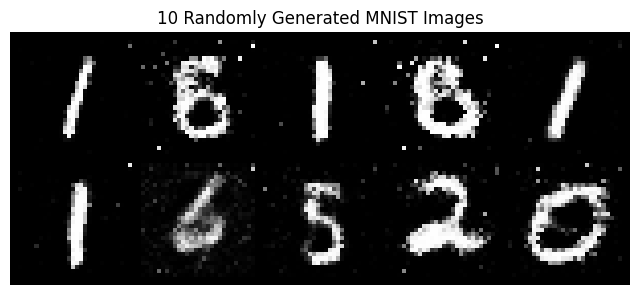

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_images(generator, num_images=10):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

generate_images(generator, num_images=10)

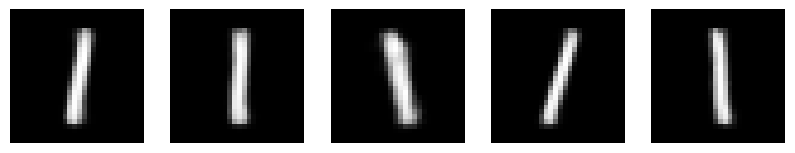

In [ ]:
def generate_specific_digit(generator, num_images=20, target_digit=1):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(10, 5))
    count = 0
    for i in range(num_images):
        img = generated_images[i].reshape(28, 28)
        plt.subplot(2, 5, count + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        count += 1
        if count == 5:
            break
    plt.show()

generate_specific_digit(generator, num_images=20, target_digit=1)

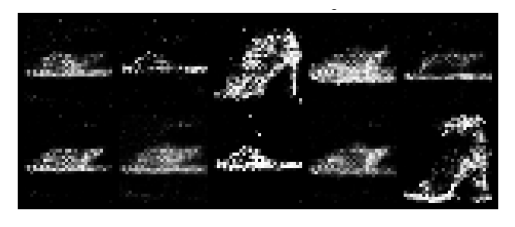

In [1]:
generate_images(generator, num_images=10)

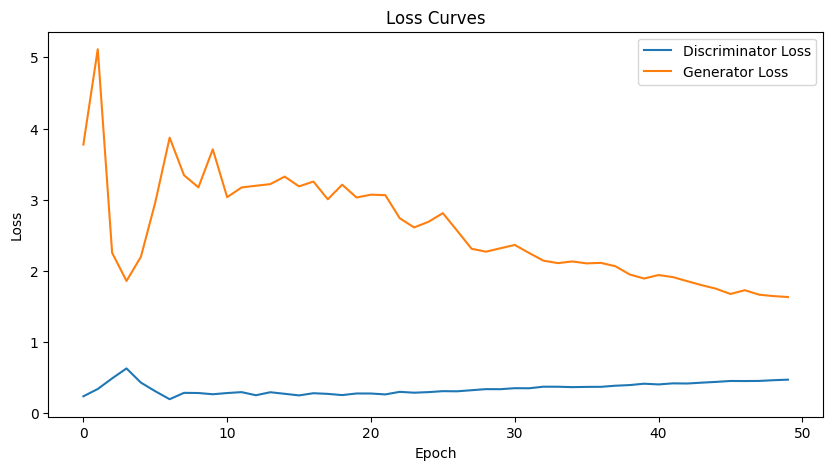

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Loss Curves")
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Part 3: Implementing Variational Autoencoder (VAE)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)  # Mean of latent space
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log variance of latent space

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Output scaled between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + kl_div


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize VAE
vae = VAE(latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch, (x, _) in enumerate(train_loader):
        x = x.view(-1, 28 * 28)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.84MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.60MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 174.4844
Epoch [2/10], Loss: 155.6118
Epoch [3/10], Loss: 150.9863
Epoch [4/10], Loss: 148.1417
Epoch [5/10], Loss: 146.3915
Epoch [6/10], Loss: 144.9576
Epoch [7/10], Loss: 143.9936
Epoch [8/10], Loss: 143.1483
Epoch [9/10], Loss: 142.6029
Epoch [10/10], Loss: 142.0106


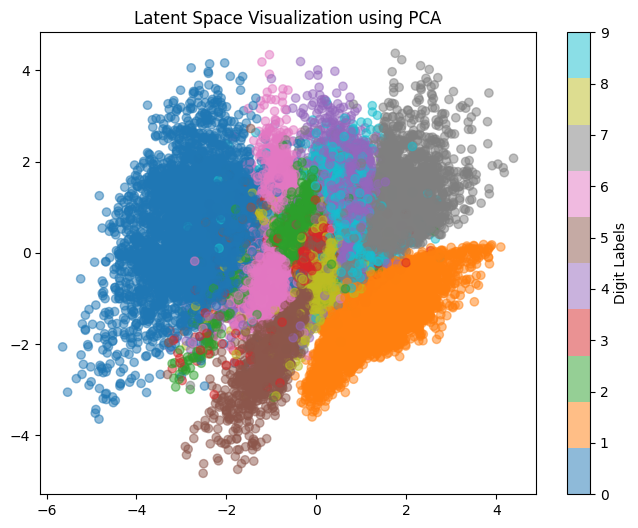

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

vae.eval()
latent_vectors = []
labels = []

for batch, (x, y) in enumerate(train_loader):
    x = x.view(-1, 28 * 28)
    _, mu, _ = vae(x)
    latent_vectors.append(mu.detach().numpy())
    labels.append(y.numpy())

latent_vectors = np.vstack(latent_vectors)
labels = np.concatenate(labels)

# Use PCA or t-SNE for dimensionality reduction
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.colorbar(label='Digit Labels')
plt.title('Latent Space Visualization using PCA')
plt.show()


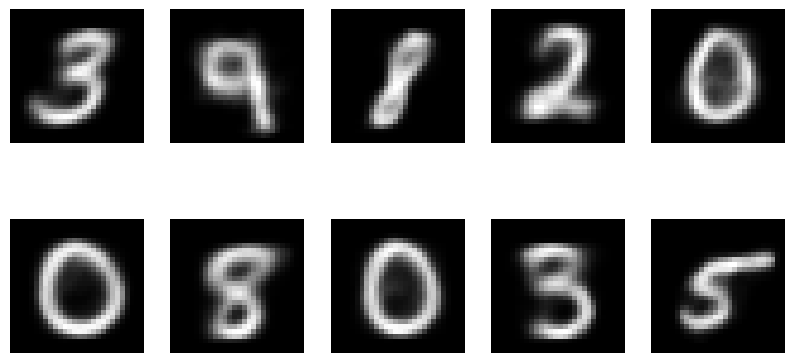

In [ ]:
def generate_images(num_images=10):
    z = torch.randn(num_images, 2)  # Sample random latent vectors
    generated_images = vae.decoder(z).detach().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate new images
generate_images(num_images=10)


Now that your VAE model has been successfully trained, proceed with the

following tasks

In [ ]:
digit_latents = {}

vae.eval()
with torch.no_grad():
    for batch, (x, y) in enumerate(train_loader):
        x = x.view(-1, 28 * 28)
        _, mu, _ = vae(x)
        for i in range(x.shape[0]):
            digit = y[i].item()
            if digit not in digit_latents:
                digit_latents[digit] = []
            digit_latents[digit].append(mu[i].numpy())

# Convert lists to numpy arrays
for key in digit_latents:
    digit_latents[key] = np.array(digit_latents[key])


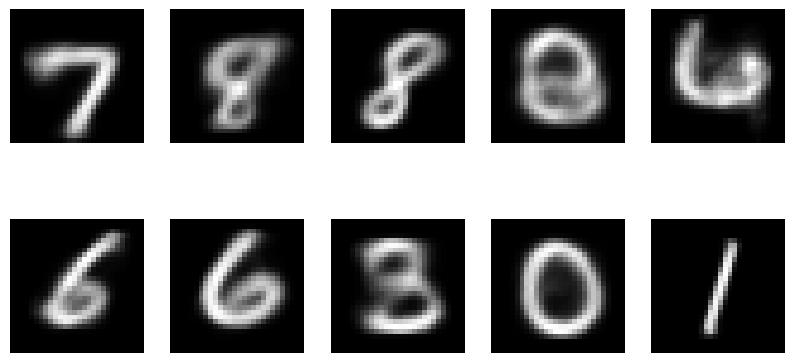

In [ ]:
def generate_images(num_images=10):
    z = torch.randn(num_images, 2)  # Sample random latent vectors
    generated_images = vae.decoder(z).detach().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate new images
generate_images(num_images=10)


<ipython-input-7-92395606d4a3>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_mnist_digits.pth', map_location=device))


Training MNIST classifier ...
Epoch 1, Loss: 0.1595
Epoch 2, Loss: 0.0459


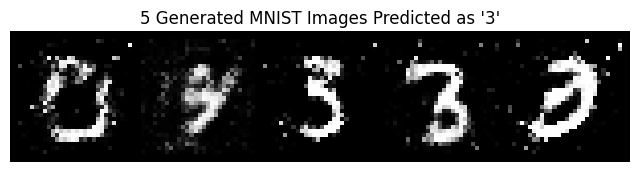

In [ ]:
def generate_specific_digit(digit, num_images=5):
    if digit not in digit_latents:
        print(f"Digit {digit} not found in stored latent vectors!")
        return

    sampled_latents = torch.tensor(digit_latents[digit][:num_images], dtype=torch.float32)
    generated_images = vae.decoder(sampled_latents).detach().numpy()

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate images of digit "1"
generate_specific_digit(digit=3, num_images=5)

In [ ]:
fashion_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_loader = DataLoader(fashion_dataset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 311kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
vae_fashion = VAE(latent_dim=2)  # Create a new VAE model
optimizer_fashion = optim.Adam(vae_fashion.parameters(), lr=1e-3)

num_epochs = 10
vae_fashion.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch, (x, y) in enumerate(fashion_loader):
        x = x.view(-1, 28 * 28)
        optimizer_fashion.zero_grad()
        x_recon, mu, logvar = vae_fashion(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer_fashion.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(fashion_loader.dataset):.4f}")


Epoch [1/10], Loss: 281.6676
Epoch [2/10], Loss: 264.6181
Epoch [3/10], Loss: 261.8701
Epoch [4/10], Loss: 260.1629
Epoch [5/10], Loss: 259.3628
Epoch [6/10], Loss: 258.3449
Epoch [7/10], Loss: 257.7995
Epoch [8/10], Loss: 257.1686
Epoch [9/10], Loss: 256.8312
Epoch [10/10], Loss: 256.2795


In [ ]:
fashion_latents = {}

vae_fashion.eval()
with torch.no_grad():
    for batch, (x, y) in enumerate(fashion_loader):
        x = x.view(-1, 28 * 28)
        _, mu, _ = vae_fashion(x)
        for i in range(x.shape[0]):
            label = y[i].item()
            if label == 9:  # Class 9 corresponds to shoes
                if label not in fashion_latents:
                    fashion_latents[label] = []
                fashion_latents[label].append(mu[i].numpy())

for key in fashion_latents:
    fashion_latents[key] = np.array(fashion_latents[key])


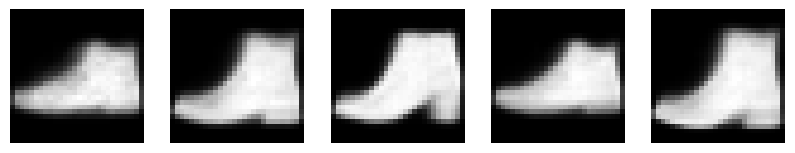

In [ ]:
def generate_shoe_images(num_images=5):
    if 9 not in fashion_latents:
        print("Shoe images not found in stored latent vectors!")
        return

    sampled_latents = torch.tensor(fashion_latents[9][:num_images], dtype=torch.float32)
    generated_images = vae_fashion.decoder(sampled_latents).detach().numpy()

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate shoe images
generate_shoe_images(num_images=5)


# **Part 4: Comparison and Analysis**

### **1. Image Quality**
**GANs**: GANs typically generate sharper and more realistic images compared to VAEs. The adversarial training process forces the generator to produce images that resemble real samples, which often results in high-quality outputs. However, GANs suffer from mode collapse, where they generate limited variations of images instead of capturing the full diversity of the dataset.

**VAEs**: VAEs, on the other hand, generate blurrier images because they optimize for a probabilistic reconstruction loss (such as Mean Squared Error) combined with a KL divergence term. While VAEs excel at learning structured latent spaces, their image outputs tend to lack fine details due to the regularization imposed on the latent space.

**Conclusion**: GANs produce sharper images, but VAEs generate more diverse samples and maintain better latent space structure.


### **2. Training Stability**
**GANs**: Training GANs is notoriously difficult because they involve a min-max game between the generator and the discriminator. If either network becomes too strong, training can become unstable. Common issues include mode collapse (generator producing similar images repeatedly) and vanishing gradients.

**VAEs**: VAEs are much more stable to train since they use a reconstruction-based loss and KL divergence regularization. The optimization process is straightforward, making VAEs easier to tune and scale compared to GANs.

**Conclusion**: VAEs are significantly easier to train and converge more reliably, while GANs require careful tuning of hyperparameters and loss balancing.


### **3. Latent Space Representation**
**GANs**: GANs do not explicitly learn a well-structured latent space. While the generator learns to map random noise to realistic images, there is no clear way to interpolate between different generated samples in a meaningful way.

**VAEs**: VAEs explicitly model the latent space as a structured probability distribution, making them ideal for tasks like interpolation, clustering, and anomaly detection. The latent space of VAEs allows smooth transitions between different image classes, whereas GANs struggle with structured transitions.

**Conclusion**: VAEs provide a well-structured latent space useful for downstream tasks, while GANs primarily focus on realistic image generation without enforcing latent space structure.


### **4. Potential Improvements**
#### **GAN Improvements:**
- **Use Wasserstein GAN (WGAN)**: Helps with training stability and improves diversity.
- **Apply Spectral Normalization**: Prevents discriminator from overpowering the generator.
- **Use Progressive Growing**: Starts training at low resolution and gradually increases.
- **Improve Noise Input (StyleGAN-like architectures)**: Enhances control over generation.

#### **VAE Improvements:**
- **Use Beta-VAE**: Enhances disentanglement in latent space.
- **Increase Latent Space Size**: Helps capture more complex patterns.
- **Use Perceptual Loss (instead of MSE/BCE)**: Results in sharper images.
- **Hybrid Approach (VAE + GANs, like VAE-GAN)**: Combines the benefits of both models.



# **Part 5: Save world with VAE**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Display basic info
print(df.info())

# Check the first few rows
print(df.head())

# Check class distribution
print(df["Class"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Standardize the 'Amount' column
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

# Drop the 'Time' column
df.drop(columns=["Time"], inplace=True)

In [ ]:
# Separate normal and fraudulent transactions
df_normal = df[df["Class"] == 0]  # Normal transactions
df_fraud = df[df["Class"] == 1]  # Fraudulent transactions

print(f"Normal transactions: {len(df_normal)}")
print(f"Fraudulent transactions: {len(df_fraud)}")


Normal transactions: 284315
Fraudulent transactions: 492


In [ ]:
# Split normal transactions into train (80%) and validation (20%)
train_data, val_data = train_test_split(df_normal, test_size=0.2, random_state=42)

# Use both normal and fraud transactions for testing
test_data = pd.concat([val_data, df_fraud])

# Drop the class label for training (since VAE is unsupervised)
train_data = train_data.drop(columns=["Class"])
test_labels = test_data["Class"]  # Save labels for evaluation
test_data = test_data.drop(columns=["Class"])

# Convert to numpy arrays for training
train_data = train_data.values
test_data = test_data.values

print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")


Train set shape: (227452, 29)
Test set shape: (57355, 29)


VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2_mu = nn.Linear(32, latent_dim)  # Mean
        self.fc2_logvar = nn.Linear(32, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # Output is probability

    def forward(self, x):
      mu, logvar = self.encode(x)
      z = self.reparameterize(mu, logvar)
      recon_x = self.decode(z)
      return recon_x, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")  # MSE reconstruction loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + kl_div


In [ ]:
# Model parameters
input_dim = train_data.shape[1]  # Number of features
latent_dim = 2  # Latent space size

# Initialize model, optimizer
vae = VAE(input_dim, latent_dim).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Convert data to tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

# Training loop
epochs = 50
batch_size = 256
num_batches = len(train_tensor) // batch_size

for epoch in range(epochs):
    vae.train()
    total_loss = 0

    for i in range(0, len(train_tensor), batch_size):
        batch = train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)  # ✅ This should work if the forward method is correctly defined
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_tensor):.4f}")


Epoch 1, Loss: 30.8595
Epoch 2, Loss: 29.5975
Epoch 3, Loss: 29.2561
Epoch 4, Loss: 29.0905
Epoch 5, Loss: 29.0214
Epoch 6, Loss: 28.9651
Epoch 7, Loss: 28.9007
Epoch 8, Loss: 28.8486
Epoch 9, Loss: 28.8297
Epoch 10, Loss: 28.7961
Epoch 11, Loss: 28.7752
Epoch 12, Loss: 28.7488
Epoch 13, Loss: 28.7301
Epoch 14, Loss: 28.7263
Epoch 15, Loss: 28.7152
Epoch 16, Loss: 28.7081
Epoch 17, Loss: 28.6960
Epoch 18, Loss: 28.6842
Epoch 19, Loss: 28.6688
Epoch 20, Loss: 28.6467
Epoch 21, Loss: 28.6444
Epoch 22, Loss: 28.6472
Epoch 23, Loss: 28.6424
Epoch 24, Loss: 28.6219
Epoch 25, Loss: 28.6302
Epoch 26, Loss: 28.6177
Epoch 27, Loss: 28.6165
Epoch 28, Loss: 28.6133
Epoch 29, Loss: 28.6040
Epoch 30, Loss: 28.5971
Epoch 31, Loss: 28.5963
Epoch 32, Loss: 28.5965
Epoch 33, Loss: 28.5874
Epoch 34, Loss: 28.5891
Epoch 35, Loss: 28.5875
Epoch 36, Loss: 28.5814
Epoch 37, Loss: 28.5756
Epoch 38, Loss: 28.5702
Epoch 39, Loss: 28.5725
Epoch 40, Loss: 28.5681
Epoch 41, Loss: 28.5596
Epoch 42, Loss: 28.5653
E

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Extract only normal transactions (label = 0)
normal_data = df[df['Class'] == 0].drop(columns=['Class']).values

# Convert to PyTorch tensors
normal_data = torch.tensor(normal_data, dtype=torch.float32)

# Train-test split
train_data, test_data = train_test_split(normal_data, test_size=0.2, random_state=42)

# Convert to DataLoader
train_loader = DataLoader(TensorDataset(train_data), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=64, shuffle=False)


In [ ]:
def reconstruction_error(model, data_loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            recon_x, _, _ = model(x)
            loss = torch.mean((x - recon_x) ** 2, dim=1)  # MSE per sample
            errors.extend(loss.cpu().numpy())
    return np.array(errors)

# Compute reconstruction errors for normal transactions (train set)
train_errors = reconstruction_error(vae, train_loader)

# Set threshold: Mean + 3 standard deviations (adjust if needed)
threshold = np.mean(train_errors) + 3 * np.std(train_errors)
print(f"Threshold for anomaly detection: {threshold}")

Threshold for anomaly detection: 12.281357049942017


In [ ]:
# Get normal and fraud test transactions
normal_test = df[df['Class'] == 0].drop(columns=['Class']).values
fraud_test = df[df['Class'] == 1].drop(columns=['Class']).values

normal_test = torch.tensor(normal_test, dtype=torch.float32)
fraud_test = torch.tensor(fraud_test, dtype=torch.float32)

normal_loader = DataLoader(TensorDataset(normal_test), batch_size=64, shuffle=False)
fraud_loader = DataLoader(TensorDataset(fraud_test), batch_size=64, shuffle=False)

# Compute reconstruction errors
normal_errors = reconstruction_error(vae, normal_loader)
fraud_errors = reconstruction_error(vae, fraud_loader)

# Classify transactions
normal_preds = normal_errors > threshold
fraud_preds = fraud_errors > threshold

# Calculate accuracy
normal_accuracy = np.mean(normal_preds == False)  # Should be mostly False
fraud_accuracy = np.mean(fraud_preds == True)  # Should be mostly True

print(f"Detection Accuracy - Normal Transactions: {normal_accuracy:.2%}")
print(f"Detection Accuracy - Fraudulent Transactions: {fraud_accuracy:.2%}")


Detection Accuracy - Normal Transactions: 99.46%
Detection Accuracy - Fraudulent Transactions: 43.90%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


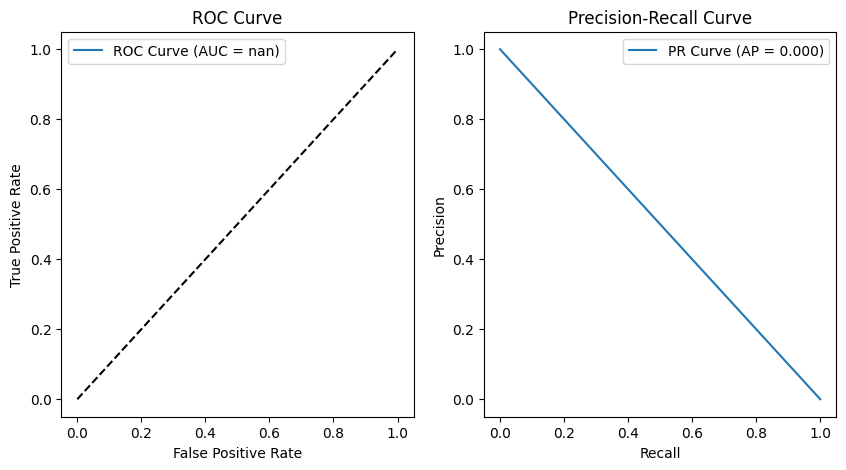

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Function to compute reconstruction error
def compute_reconstruction_error(vae, dataloader):
    vae.eval()  # Set model to evaluation mode
    errors = []
    labels = []

    with torch.no_grad():
        for batch, in dataloader:
            recon_batch, _, _ = vae(batch)
            error = torch.mean((recon_batch - batch) ** 2, dim=1).cpu().numpy()
            errors.extend(error)
            labels.extend([1 if 'fraud' in dataloader.dataset.tensors else 0] * len(batch))  # Assign labels

    return np.array(errors), np.array(labels)

# Compute reconstruction errors
normal_errors, normal_labels = compute_reconstruction_error(vae, test_loader)
fraud_errors, fraud_labels = compute_reconstruction_error(vae, fraud_loader)  # Assuming fraud_loader contains fraud samples

# Combine errors & labels
errors = np.concatenate([normal_errors, fraud_errors])
labels = np.concatenate([normal_labels, fraud_labels])

# Compute ROC Curve
fpr, tpr, _ = roc_curve(labels, errors)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, errors)
pr_auc = average_precision_score(labels, errors)

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()
